<a href="https://colab.research.google.com/github/jpan0829/Reverse_Image_Search/blob/main/Reverse_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import os
import tarfile
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, ConfusionMatrixDisplay,roc_curve, auc

###Data Visulization

In [ ]:
ds, info = tfds.load('lfw', split='train', with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete34TM9E/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


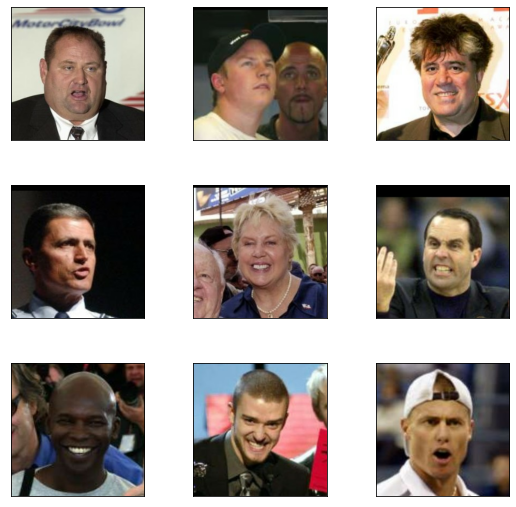

In [ ]:
fig = tfds.show_examples(ds, info)

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)



###Download Data

In [ ]:
url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
r = requests.get(url)
filename = 'lfw.tar.gz'
folderdername = filename.split('.')[0]
open(filename , 'wb').write(r.content)


180566744

In [ ]:
if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
elif filename.endswith("tar"):
    tar = tarfile.open(filename, "r:")
    tar.extractall()
    tar.close()

In [ ]:
img_size =224
batch_size = 128

###Create DataGenerator with preprocess_input for Resnet

In [ ]:
root_dir = 'lfw'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)


Found 13233 images belonging to 5749 classes.


###ResNet50 Define model without top ->get features instead of probability

In [ ]:
model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

In [ ]:
feature_list = model.predict(datagen, num_epochs)

In [ ]:
feature_list.shape

(13233, 2048)

In [ ]:
len(datagen.classes)

13233

In [ ]:
len(datagen.filenames)

13233

###KNN

In [ ]:
neighbors = NearestNeighbors(n_neighbors=7,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean', n_neighbors=7)

###Test Image

In [ ]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber+=1
    plt.tight_layout()


In [ ]:
def similar_search(path):
  img_path = path
  input_shape = (img_size, img_size, 3)
  img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
  preprocessed_img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
  test_img_features = model.predict(preprocessed_img, batch_size=1)
  _, indices = neighbors.kneighbors(test_img_features)
  plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
  plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
  plt.show()
  print('********* Predictions ***********')
  similar_images(indices[0])

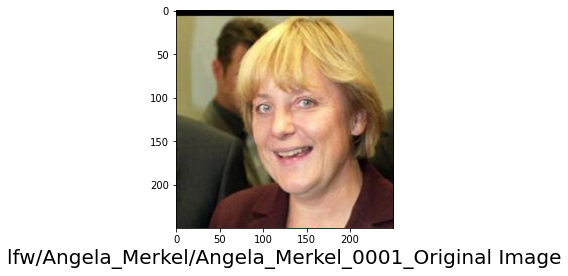

********* Predictions ***********


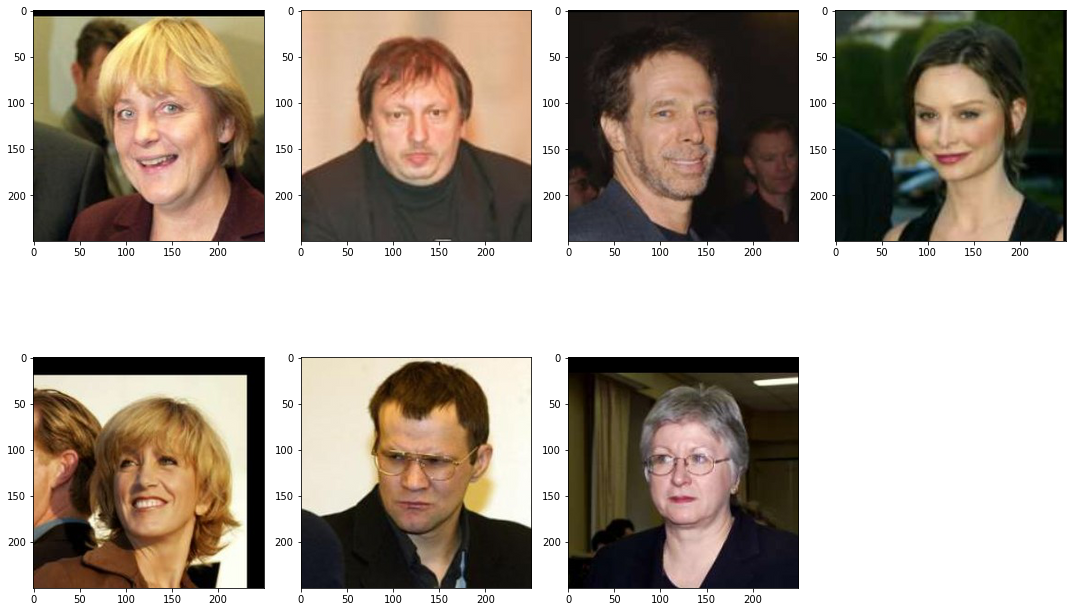

In [ ]:
similar_search('lfw/Angela_Merkel/Angela_Merkel_0001.jpg')